In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
from IPython.display import Image, display
import re
import string
from numpy import array


In [5]:
import tensorflow as tf  
print(tf.__version__)    
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint   
import time
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
from tensorflow.python.keras.layers.pooling import GlobalMaxPool2D
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint


2.7.0


In [6]:
!wget https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_3/main/Flickr_8k.trainImages.txt

--2021-12-31 15:05:49--  https://raw.githubusercontent.com/Nadiam75/DeepLearning_HW_3/main/Flickr_8k.trainImages.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154678 (151K) [text/plain]
Saving to: ‘Flickr_8k.trainImages.txt.2’

Flickr_8k.trainImag 100%[===================>] 151.05K  --.-KB/s    in 0.03s   

2021-12-31 15:05:50 (5.44 MB/s) - ‘Flickr_8k.trainImages.txt.2’ saved [154678/154678]



In [7]:
! pip install kaggle
# !wget https://github.com/Nadiam75/DeepLearning_HW_3/blob/main/kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# !unzip -q /content/flickr8k.zip

In [9]:
images_path = './Images/'
captions_path = 'captions.txt'

In [10]:
captions = open(captions_path, 'r').read().split("\n")

In [11]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split(",")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][:])
    else:
        tokens[temp[0]] = [temp[1][:]]

In [12]:
tokens['1003163366_44323f5815.jpg']

['A man lays on a bench while his dog sits by him .',
 'A man lays on the bench to which a white dog is also tied .',
 'a man sleeping on a bench outside with a white and black dog sitting next to him .',
 'A shirtless man lies on a park bench with his dog .',
 'man laying on bench holding leash of dog sitting on ground']

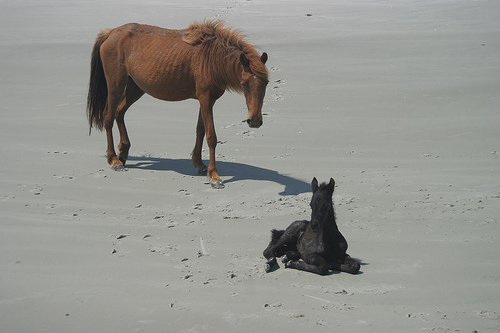

A brown horse and a black foal on the beach
A brown horse stands near a black horse that is sitting on the ground .
A large brown horse stands over a small black colt that is kneeling on the sand .
An adult horse approaching a foal on a sandy plain .
A thin brown horse standing and a small black horse sitting on sand .


In [13]:
temp = captions[1000].split(",")
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

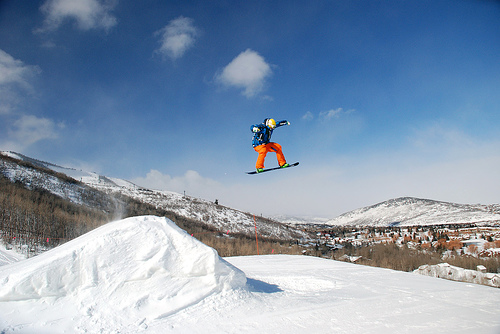

A man jumps off a ramp on a snowboard .
A snowboarder high in the air .
A snowboarder jumps through the air on their snowboard .
"Snowboarder flies off of snowy jump 
The snowboarder is in the middle of a very tall jump


In [14]:
temp = captions[6000].split(",")
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [15]:
if 'image' in tokens.keys():
  del tokens['image']


In [16]:
i = 0
for key, value in tokens.items():
  i+=1
  if i>5:
    break
  print(key)  
  print("***********************")
  for j in range(len(value)):
    print(value[j])
  # print(value)
  print("----------------------------------------------------------------------------------------")

1000268201_693b08cb0e.jpg
***********************
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .
----------------------------------------------------------------------------------------
1001773457_577c3a7d70.jpg
***********************
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
----------------------------------------------------------------------------------------
1002674143_1b742ab4b8.jpg
***********************
A little girl covered in paint sits in front of a painted rainbow with her hands in a 

In [17]:
def sentence_cleaning(sentence  ):
    sentence=sentence.lower()
    sentence=re.sub('[^a-z]+',' ',sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=' '.join(sentence)
    return(sentence)

In [18]:
sentence_cleaning('Two dogs on pavement moving toward each other .' )

'two dogs on pavement moving toward each other'

In [19]:
sentence_cleaning('A young child is walking on 22 stones paved street with a metal pole and a man behind him .' )

'young child is walking on stones paved street with metal pole and man behind him'

In [20]:
i = 0
all_words = []
unique = set()
occurances = {}
clean_dictionary = {}
for key, value in tokens.items():
  for j in range(len(value)):
    if key in clean_dictionary:

      cleaned = sentence_cleaning(value[j] )
      clean_dictionary[key].append( cleaned)
    else:
      cleaned = sentence_cleaning(value[j] )
      clean_dictionary[key] = [cleaned]
    words = cleaned.split(' ')
    # all_words = all_words + words
    # print(words)
    # all_words.append [ ]
    for word in words:
      unique.add(word)


In [21]:
all_words = unique

In [22]:
clean_dictionary['934375844_dd149fed18.jpg']

['baby in white top is sitting on bed',
 'baby wearing my best buddy shirt on bed',
 'cute baby boy is sitting on the bed looking very happy',
 'small baby sits on bed and smiles',
 'small boy wearing blue shorts sitting on bed']

In [23]:
occurances = {}

for key, value in clean_dictionary.items():
  for j in range(len(value)):
    
    words = value[j].split(' ')
    for word in words:
      if word in occurances :
        occurances [word] +=1
      else:
        occurances[word] = 1

In [24]:
len(occurances)

8258

In [25]:
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [26]:
vocabulary = to_vocabulary(clean_dictionary)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8257


In [27]:
cnt=0
low_occurance_dictionary = {}
low_occurance_keys = []
for key, value in occurances.items():
  if value<10:
    print(key)
    cnt+=1
    low_occurance_dictionary[' ' +key+ ' '] = value
    low_occurance_keys.append(' '+key+ ' ')
    unique.remove(key)


Streaming output truncated to the last 5000 lines.
recreation
boulders
casual
eachothers
parasail
parasailors
shadowed
bruised
rental
bookcase
videos
foggyday
prow
heading
package
asking
witnesses
dealth
signpost
library
bookstore
trip
dalmatian
lease
hotel
island
woven
toboggan
knitted
poof
woolen
identically
pajama
bit
overcoat
glassses
snowstorm
goatee
galloping
rivers
laundry
cliffs
utensils
implements
fork
knife
utilities
menacingly
environment
grimmaces
raging
strong
currents
rafter
steamy
rapid
kayacker
downstream
mani
calmer
pyranha
whose
snowman
couples
hummer
damaged
carried
repair
tow
peach
laid
mistletoe
theme
australian
necks
cautious
rugged
region
sleeves
miles
someplace
distnat
hate
fists
tough
cheap
mean
spring
tunic
whist
waterway
places
snuggles
tinted
chin
crocodile
posed
dangerous
jaw
ankle
scratch
contorted
harmonica
guiutarist
looming
thermos
gazing
mountian
topped
traveller
glacier
ballet
fairy
nutcracker
butterfly
turquiose
chow
mix
euro
plats
messy
junk
contrac

In [28]:
cnt

6347

In [29]:
len(low_occurance_keys)

6347

In [30]:
vocab_size = len(unique)
vocab_size

1911

In [31]:
len(low_occurance_dictionary)

6347

In [32]:
len(all_words)

1911

In [33]:
low_occurance_dictionary

{' entry ': 1,
 ' playhouse ': 6,
 ' cabin ': 4,
 ' breeds ': 5,
 ' fingerpaints ': 3,
 ' canvas ': 6,
 ' starring ': 8,
 ' gauges ': 2,
 ' blitz ': 1,
 ' crocheted ': 1,
 ' pierced ': 6,
 ' roping ': 2,
 ' grips ': 2,
 ' boston ': 9,
 ' lush ': 8,
 ' stony ': 3,
 ' aross ': 1,
 ' mottled ': 2,
 ' displaying ': 5,
 ' paintings ': 4,
 ' framed ': 7,
 ' artwork ': 4,
 ' sale ': 7,
 ' collage ': 2,
 ' belays ': 1,
 ' ascending ': 8,
 ' newborn ': 8,
 ' care ': 3,
 ' tags ': 7,
 ' frolicks ': 2,
 ' drilling ': 5,
 ' crampons ': 1,
 ' scale ': 1,
 ' gentle ': 1,
 ' snaps ': 1,
 ' lunges ': 6,
 ' too ': 6,
 ' late ': 3,
 ' captures ': 1,
 ' guarding ': 9,
 ' modern ': 5,
 ' enter ': 8,
 ' iced ': 3,
 ' skyscraper ': 6,
 ' baked ': 2,
 ' good ': 7,
 ' tin ': 1,
 ' check ': 7,
 ' hilltop ': 2,
 ' overlook ': 6,
 ' moutains ': 1,
 ' kayakers ': 8,
 ' rafts ': 6,
 ' multiracial ': 1,
 ' takeout ': 1,
 ' television ': 9,
 ' tv ': 9,
 ' teens ': 7,
 ' constructions ': 1,
 ' steel ': 4,
 ' hailing 

In [34]:
# for key, value in clean_dictionary.items():
#   for j in range(len(value)):
#     if 'swatting' in value[j]:
#       print("MESS!")

In [35]:
start_token = '<START> '
end_token = ' <END>'
pad_token = ' <PAD> '
temp = '('+'|'.join(low_occurance_keys) + ')'

In [36]:
for key, value in clean_dictionary.items():
  for j in range(len(value)):
    value[j]=re.sub( temp,'', value[j])
    value[j] = start_token + value[j] + end_token

In [37]:
i = 0
for key, value in clean_dictionary.items():
  
  i+=1
  if i>5:
    break
  print(key)  
  print("***********************")
  for j in range(len(value)):
    print(value[j])
    
  # print(value)
  print("----------------------------------------------------------------------------------------")


1000268201_693b08cb0e.jpg
***********************
<START> child in pink dress is climbing up set of stairs in anway <END>
<START> girl going into wooden building <END>
<START> little girl climbing into wooden playhouse <END>
<START> little girl climbing the stairs to her playhouse <END>
<START> little girl in pink dress going into wooden cabin <END>
----------------------------------------------------------------------------------------
1001773457_577c3a7d70.jpg
***********************
<START> black dog and spotted dog are fighting <END>
<START> black dog and tri colored dog playing with each other on the road <END>
<START> black dog and white dog with brown spots are staring at each other in the street <END>
<START> two dogs of differentlooking at each other on the road <END>
<START> two dogs on pavement moving toward each other <END>
----------------------------------------------------------------------------------------
1002674143_1b742ab4b8.jpg
***********************
<START> littl

In [38]:
with open('Flickr_8k.trainImages.txt') as f:
    trainKeys = [line.rstrip() for line in f]

In [39]:
import copy
testDictionary = copy.deepcopy(clean_dictionary)

In [40]:
trainDictionary = {}
for k in trainKeys:
  trainDictionary[k] = testDictionary [k]
  del testDictionary[k]

In [41]:
len(testDictionary)

2091

In [42]:
len(trainDictionary)

6000

In [43]:
model = VGG16()
# re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [44]:
# extract features from each photo in the directory
def encode(filename  , model ):
	# load the model

	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature
 


In [ ]:
encodedTrain = {} 
i = 0
for key, value in trainDictionary.items():
  i+=1
  print(i)
  path = 'Images/' +key
  encoded = encode(path , model )
  encodedTrain[key] = encoded

In [63]:
len(encodedTrain)

0

In [46]:
encodedTest = {} 
i=0
for key, value in testDictionary.items():
  i+=1
  print(i)
  path = 'Images/' +key
  encoded = encode(path, model)
  encodedTest[key] = encoded

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [47]:
# import pickle

# with open('saved_train_dictionary.pkl', 'wb') as f:
#     # pickle.dump(encodedTrain, f)
#     f.write(pickle.dumps(encodedTrain))
    
        
# with open('saved_train_dictionary.pkl', 'rb') as f:
#     # encodedTrain = pickle.load(f)
#     encodedTrain = pickle.loads(f.read())

In [48]:
# with open('saved_test_dictionary.pkl', 'wb') as f:
#     # pickle.dump(encodedTrain, f)
#     f.write(pickle.dumps(encodedTest))
    
        
# with open('saved_test_dictionary.pkl', 'rb') as f:
#     # encodedTrain = pickle.load(f)
#     encodedTest = pickle.loads(f.read())

In [57]:
encodedTest_1= copy.deepcopy(encodedTest)
encodedTrain_1 = copy.deepcopy(encodedTrain)
# train_Dictionary = copy.deepcopy(trainDictionary_1)

In [44]:
len(encodedTrain_1)

NameError: ignored

In [59]:
encodedTrain = {} 
maxLength = 0
for key, value in clean_dictionary.items():
  for idx in range(len(value)):
    if maxLength <len(value[j].split(' ')):
      maxLength = len(value[j].split(' '))

In [50]:
maxLength

26

In [51]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 

In [52]:
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [53]:
tokenizer = create_tokenizer(trainDictionary)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 8981


In [1]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

In [2]:
x1 , x2 , y = create_sequences(tokenizer, maxLength , trainDictionary, encodedTrain, vocab_size)

NameError: ignored

In [72]:
len(encodedTrain['2513260012_03d33305cf.jpg'][0])

4096

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
